# Feature Importance  
Author: Melvin Vellera

<a id='introduction'></a>

## Introduction
A data scientist can spend months trying to build the perfect machine learning or deep learning model that gives the most accurate results for a particular task. However, if he or she is unable to explain why the model behaves the way it does, then there might be some hesitancy from stakeholders in using the model for real world applications. This is where model interpretability and feature importances play a major role. For example, instead of only giving probabilities for whether or not people will rent an aparment, we could also explain the factors that are important to people when renting an apartment, such as the location, number of bedrooms, price and so on.

Feature importance gives a **relative ranking** of the predictive strength among the features of a model. This relative ranking could be useful for simplying and generalizing a model. There are many different ways to get feature importances and the relative ranking generally depends on the model that is used. 

In this report, multiple feature importance strategies are discussed: Spearman's Rank Correlation, PCA, mRMR, Linear Regression, Random Forest, Permutation, Drop Column, and SHAP. Moreover, procedures for comparing stratgies, and automatically selecting features have also been discussed and implemented.


## Table of Contents
1. [Dataset Descriptions](#datasets)
2. [Spearman's Rank Correlation](#spearman)
2. [Principal Component Analysis](#pca)
3. [Minimum Redundancy Maximum Relevance](#mrmr)
4. [Model Specific Importances](#linear)
    1. [Linear Regression](#linear)
    2. [Random Forest](#rf)
5. [Model Agnostic Importances](#permutation)
    1. [Permutation](#permutation)
    2. [Drop Column](#drop)
    3. [SHAP](#shap)
8. [Comparing Importance Strategies](#compare)
9. [Automatic Feature Selection](#automatic)
10. [Variance of Importances](#variance)
11. [Empirical p-values of Importances](#empirical)
11. [Conclusion](#conclusion)
12. [References](#references)

<a id='datasets'></a>

## Datasets

The following datasets are used in the report: 
1. [California Housing Dataset](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html) (For regression)
2. [Two Sigma Connect: Rental Listing Inquiries](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries) (For classification)

**California Housing Dataset**:  
The dependent variable is $\log(\text{median house value})$ where the median house value is for California districts, expressed in hundreds of thousands of dollars ($100,000). This dataset was derived from the 1990 U.S. census, using one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). A household is a group of people residing within a home. Since the average number of rooms and bedrooms in this dataset are provided per household, these columns may take surpinsingly large values for block groups with few households and many empty houses, such as vacation resorts.

In [1]:
from featimp import *
data = fetch_california_housing(as_frame=True)
regression_features = data.feature_names
regression_target = data.target_names[0]
regression_df = pd.concat((data.data, data.target), axis=1)
regression_df.head(2)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.02381,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.97188,2401.0,2.109842,37.86,-122.22,3.585


**Two Sigma Connect: Rental Listing Inquiries**:  
The dependent variable is **interest level**, which is a 3-level categorical feature consisting of levels: high (3), medium (2), and low (1). The levels for this variable were defined by bucketing the number of inquiries a listing has in the duration that the listing was live on the site. The data comes from [renthop.com](http://www.renthop.com), an apartment listing website. These apartments are located in New York City.

In [2]:
# rent.csv generated using process_rent_json function
classification_df = pd.read_csv('rent.csv')
classification_features = list(classification_df.columns.values[:-1])
classification_target = classification_df.columns.values[-1]
classification_df.head(2)

,bathrooms,bedrooms,price,longitude,latitude,interest_level
0,1.5,3,3000,-73.9425,40.7145,2
1,1.0,2,5465,-73.9667,40.7947,1


<div style="page-break-after: always; visibility: hidden"> </div>
<a id='spearman'></a>

## Spearman's Rank Correlation

Spearman rank correlation is closely related to the Pearson correlation, and both are bounded from -1 to 1 denoting a correlation between two variables. The Pearson correlation coefficient is computed using raw data values, whereas the Spearman correlation is calculated from the ranks of individual values. While the Pearson correlation coefficient is a measure of the linear relation between two variables, the Spearman rank correlation coefficient measures the monotonic relation between a pair of variables, and this relation does not necessarily have to be linear.

**Caveats:**
- Works well for independent features, but not good for codependent features.
- Groups of features with similar relationships to the response variable receive the same importance, even though just one should be considered important.

We can see how Spearman's rank correlation works using some dummy data:

In [3]:
# Dummy data
x = np.array([-2, -1, 0, 1, 2])
y = np.array([4, 1, 3, 2, 0])

# Compute ranks (Ordinal method)
x_r = np.argsort(x) + 1 
y_r = np.argsort(y) + 1
print(f'X (Actuals): {x}\nX (Converted to Ranks): {x_r}')
print(f'\nY (Actuals): {y}\nY (Converted to Ranks): {y_r}')

X (Actuals): [-2 -1  0  1  2]
X (Converted to Ranks): [1 2 3 4 5]

Y (Actuals): [4 1 3 2 0]
Y (Converted to Ranks): [5 2 4 3 1]


We then compute the Pearson correlation coefficient on these ranks

In [4]:
spearman_correlation = pearson_correlation(x_r, y_r)
print(f"Spearman correlation: {spearman_correlation}")

Spearman correlation: -0.7


We can confirm that this matches with the implementation in the scipy library.

In [5]:
scipy_spearman = spearmanr(x_r, y_r)
print(f"Spearman correlation (Scipy): {scipy_spearman[0]}")

Spearman correlation (Scipy): -0.7


When there are a lot of ties in the data, method="average" is preferred (used in scipy) which converts raw data to rankings as follows:

In [6]:
# Dummy data
x = np.array([-2, -2, 0, 2, 2])

# Compute ranks (Average method)
x_r = rankdata(x) 
print(f'X (Actuals): {x}\nX (Converted to Ranks): {x_r}')

X (Actuals): [-2 -2  0  2  2]
X (Converted to Ranks): [1.5 1.5 3.  4.5 4.5]


Now let's get feature importances using Spearman's correlation coefficient for our regression dataset.

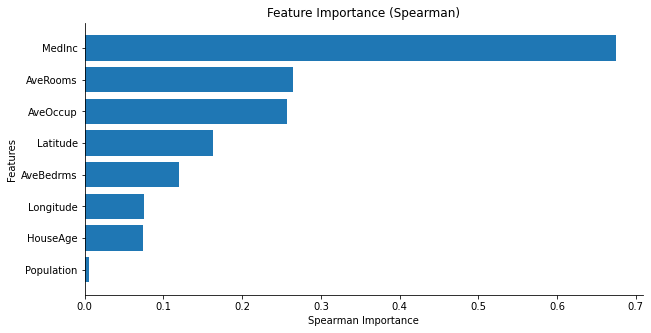

In [7]:
X_train_r, y_train_r, X_test_r, y_test_r = get_train_test_split(regression_df, 
                                                                regression_features, 
                                                                regression_target)
spearman_imp = spearman_importance(X_train_r, y_train_r)
hbar(spearman_imp['feature'], 
     spearman_imp['importance'], 
     'Spearman Importance', 'Features', 'Feature Importance (Spearman)')


From the above plot, it seems that median income is a very important factor for determining median house value.

**Note:** The range for correlation is between -1 and 1. Influential features have very high positive values (near +1) or very high negative values (near -1). Non-influential features have values around 0. Hence, we take the **absolute** value of the Spearman correlation coefficient while computing feature importances from it.

<a id='pca'></a>

## Principal Component Analysis

Principal Component Analysis (PCA) is a technique generally used for dimensionality reduction, but it can also be used to determine feature importance.

PCA returns N principal components, where N equals the number of original features. All of these principal components are a linear combination of these original features. In general, the first few principal components explain most of the variation in the source data.

For getting feature importances we can use the PCA loadings, which are the coefficients of the linear combination of the original variables from which the principal components are constructed. These loadings can be used to determine the correlations between actual variables and principal components. If there’s a strong correlation between the principal component and the original variable, it means this feature is important with respect to that principal component.

If the first principal component covers a large percentage of the variance, the loadings associated with that component can indicate importance of features in the original space.

Let's get feature importances for our dataset using PCA:

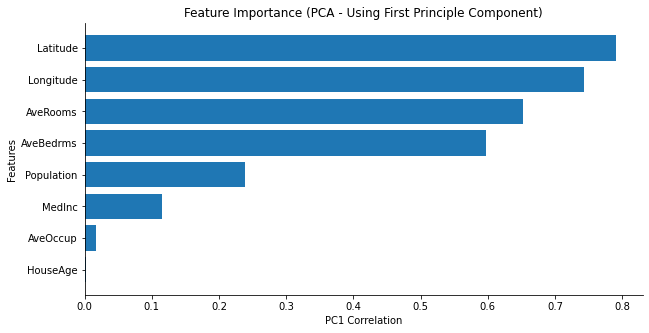

In [8]:
pca_imp = pca_importance(X_train_r)
hbar(pca_imp['feature'], 
     pca_imp['importance'], 
     'PC1 Correlation', 'Features', 'Feature Importance (PCA - Using First Principle Component)')

According to PCA, most of the variation in the dataset is with respect to location, and hence, the top 2 features are latitude and longitude.

<a id='mrmr'></a>

## Minimum Redundancy Maximum Relevance

Minimum Redundancy Maximum Relevance (mRMR) is an iterative algorithm, selecting one feature at a time based on a feature's relevance to the target and its redundancy with respect to other explanatory variables. The redundancy factor could be either subtracted from the relevance (difference method) or it can be used to divide relevance (quotient method).

**Relevance**: How well does the feature correlate to the target?  
- For categorical variables, this could be based on mutual information.  
- For continuous variables, this could be the F-statistic of that variable.  

**Redundancy**: How well does the feature correlate to features selected in previous iterations?  
The idea is that if a candidate feature correlates strongly to an already selected feature, then it won't provide much additional information to the feature set. The first feature chosen is the one that is most relevant, with no redundancy constraints.

**mRMR helps to deal with codependencies** since a feature is selected iteratively while considering redundancy with other features.

**mRMR Variants:**
1. **Mutual Information Difference (MID):**  
$$f^{MID}(X_i) = I(Y, X_i) - \frac{1}{|S|}\sum\limits_{X_s\in S}I(X_s, X_i)$$  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;where $I$ is the mutual information  
  
2. **Mutual Information Quotient (MIQ):**  
$$f^{MIQ}(X_i) = \frac{I(Y, X_i)}{\frac{1}{|S|}\sum\limits_{X_s\in S}I(X_s, X_i)}$$ 
   
3. **F-test Correlation Difference (FCD):**  
$$f^{FCD}(X_i) = F(Y, X_i) - \frac{1}{|S|}\sum\limits_{X_s\in S}\rho(X_s, X_i)$$  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;where $F$ is the F-statistic and $\rho$ is the correlation  
  
4. **F-test Correlation Quotient (FCQ):**   
$$f^{FCQ}(X_i) = \frac{F(Y, X_i)}{\frac{1}{|S|}\sum\limits_{X_s\in S}\rho(X_s, X_i)}$$  

**Note:** The **FCQ** variant of mRMR is implemented in this report with $\rho$ as the Spearman correlation.

**Caveats:**   
- mRMR only works for **classification**!
- Only considers single-feature relationships with the dependent variable.

Let's consider mRMR on our **classification dataset**:

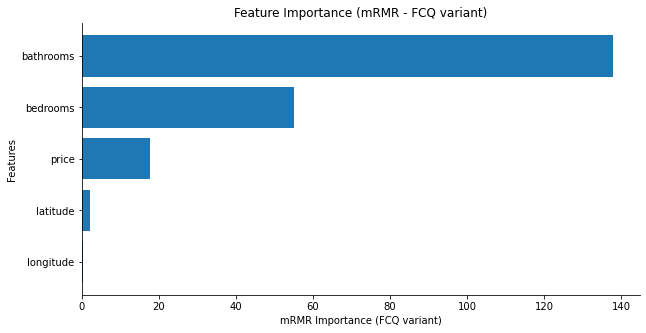

In [9]:
X_train_c, y_train_c, X_test_c, y_test_c = get_train_test_split(classification_df, 
                                                                classification_features, 
                                                                classification_target)

train_df_c = pd.concat([X_train_c, y_train_c], axis=1)
mrmr = MRMR(train_df_c.reset_index(drop=True), classification_target)
mrmr_importances = mrmr.feature_importance()
hbar(list(mrmr_importances.keys()), 
     list(mrmr_importances.values()), 
     'mRMR Importance (FCQ variant)', 'Features', 'Feature Importance (mRMR - FCQ variant)', )                                                                

According to mRMR, bathrooms and bedrooms are the most important features in determining intereset level for an apartment.

<a id='linear'></a>

## Linear Regression Importance

Linear Regression can be used to assess feature importance by using the absolute values of the model coefficents. Note that the data used must satisfy all of the assumptions required for applying linear regression.

**Caveats:**  
- Linear models are often too weak in practice for modeling and hence, the coefficient interpretation might not be optimal.
- If the assumptions are not met, then the coefficient interpretation might not be valid.

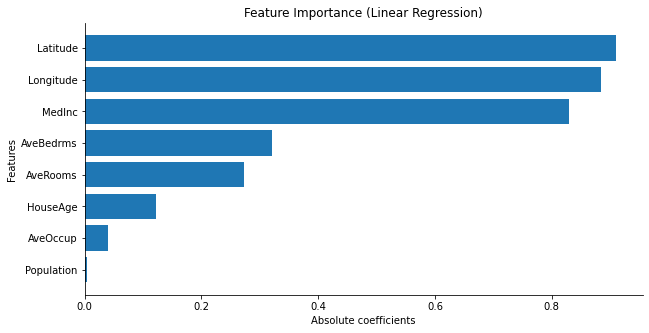

In [10]:
lr = LinearRegression()
ss = StandardScaler()
lr.fit(ss.fit_transform(X_train_r), y_train_r)
lin_imp = feature_df(X_train_r.columns.values, np.abs(lr.coef_))
hbar(lin_imp['feature'], lin_imp['importance'], 'Absolute coefficients', 'Features', 
     'Feature Importance (Linear Regression)')

According to linear regression, location and median income are important features in determining median house value.

<a id='rf'></a>

## Random Forest Importance

Random forests compute feature importances using gini drop (for classification) or mean squared error drop (for regression). For a particular feature, the average of all the loss function drops (gini or MSE) across all of its decision nodes is the feature's importance. For particular a decision node, the loss function drop is measured from the decision node to its children. If the average loss function drop for a feature is high, then the feature is important.

**Caveat:**
Random forests give biased feature importances.  

**Why does Random Forests give biased feature importances?**  
Since a Random Forest exhaustively tests every unique value when trying to find the optimal decision node split, the likelihood of finding an optimal value purely by chance increases.
Hence, **high cardinality variables** can appear more often in the trees, which leads to inflated or biased importances.

We can prove this by adding a "random" feature to the data and checking the feature importances generated by the Random Forest.

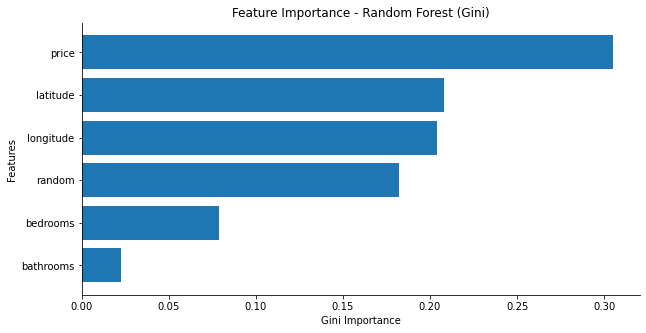

In [11]:
# Add random feature to train and test
X_train_c['random'] = np.random.random(size=len(X_train_c))
X_test_c['random'] = np.random.random(size=len(X_test_c))

# Fit Random Forest Classifier
rf = RandomForestClassifier(min_samples_leaf=5, n_jobs=-1, random_state=2).fit(X_train_c.values, y_train_c)
rf_imp = feature_df(X_train_c.columns.values, rf.feature_importances_)
hbar(rf_imp['feature'], rf_imp['importance'], 'Gini Importance', 'Features', 'Feature Importance - Random Forest (Gini)')

As seen from the above plot, the "random" feature seems to be more important than bedrooms and bathrooms according to Random Forest's importance mechanism. Clearly, this is not right.

<a id='drop'></a>

## Drop Column Importance

Drop column importance is a brute force mechanism to examine the importance of any feature or combination of features. The procedure is as follows:
1. Compute baseline validation metric for model trained on all features
2. For every column:  
    1. Drop column from training set
    2. Retrain model on new training set
    3. Compute new validation metric 
    4. Calculate difference between new and baseline validation metric (this is the importance score)
3. Return importance scores for all columns

The advantage of drop column importance is that it is a model agnostic procedure. It's also easy to understand and simple to implement.

**Caveat:**  
- Very expensive to compute because a new model has to be retrained every time a feature is dropped. Hence, the model has to be trained *p* times for *p* features. If *p*>100, then this procedure might not be feasible.
- Codependent features result in 0 or very low importance.



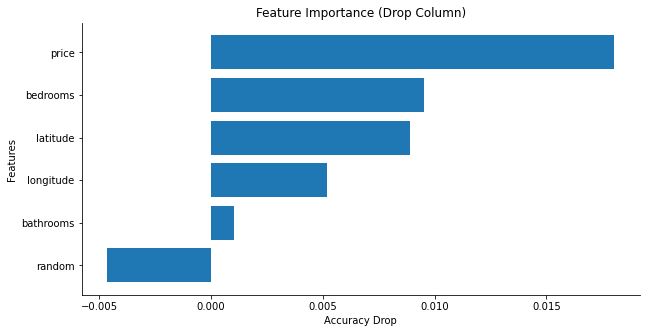

In [12]:
d_imps = dropcol_importances(rf, X_train_c, y_train_c, X_test_c, y_test_c, accuracy_score)
drop_imp_ = feature_df(X_train_c.columns.values, d_imps)
hbar(drop_imp_['feature'], drop_imp_['importance'], 'Accuracy Drop', 'Features', 
     'Feature Importance (Drop Column)')

Wow! The "random" feature has negative importance now. What does this mean? This means that the model **improved** by dropping the random feature.

<a id='permutation'></a>

## Permutation Importance

Permutation importance is similar to drop column importance, and it overcomes the major limitation of drop column importance i.e retraining the model for each feature drop. Permutation importance overcomes this by permuting the values of the feature instead of dropping the feature. When the values of the feature are permuted, the relationship between the original feature and the dependent variable is broken. Hence, we can compute the change in validation metric for the original and permuted feature and get the feature's importance.

The procedure is as follows:
1. Compute baseline validation metric for model trained on all features
2. For each column
    1. Permute column values in validation set
    2. Compute new validation metric
    3. Calculate difference between new and baseline validation metric (this is the importance score)
3. Return importance scores for all columns

Permuation importance is a model agnostic procedure. It's easy to understand and simple to implement. Importantly, it is much more efficient than drop column importance since no model re-training is required.

**Caveats:**
- Can create nonsensical records (such as pregnant male), which could make the results questionable.
- Codependent features often share importance, such as longitude and latitude.

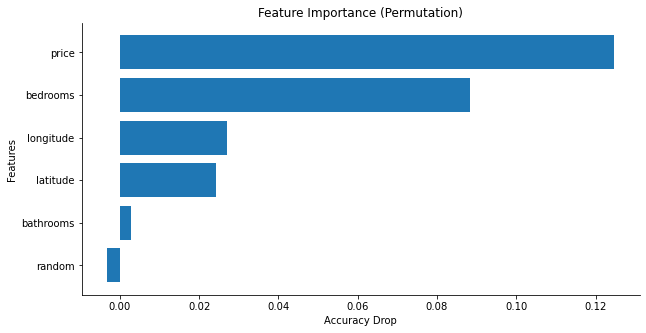

In [13]:
perm_imp_ = pd.DataFrame({'feature': X_train_c.columns.values, 
                       'importance': permutation_importances(rf, X_test_c, y_test_c, accuracy_score)})
perm_imp_ = perm_imp_.sort_values('importance', ascending=False)
hbar(perm_imp_['feature'], 
     perm_imp_['importance'], 
     'Accuracy Drop', 'Features', 'Feature Importance (Permutation)')

The random feature is at the bottom, as it should be, using permutation importance.

### Effect of duplicated columns (extreme codependence) on drop column and permutation importance

For reference, let's compute feature importances for the regression dataset using permutation importance.

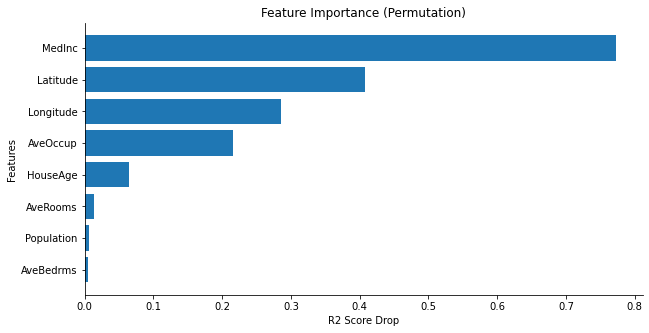

In [14]:
# Fit Random Forest Regressor
rf = RandomForestRegressor(min_samples_leaf=5, n_jobs=-1, random_state=1).fit(X_train_r.values, y_train_r)

# Permutation Importance
p_imps = permutation_importances(rf, X_test_r, y_test_r, r2_score)
perm_imp = feature_df(X_train_r.columns.values, p_imps)
hbar(perm_imp['feature'], perm_imp['importance'], 'R2 Score Drop', 'Features', 
     'Feature Importance (Permutation)')

We can see that MedInc (Median Income) is the most significant feature according to permutation importance.

We can illustrate the effect of codepenent variables by **taking codependence to its extremes: duplication**. For the example, let's duplicate the "MedInc" feature and recompute the feature importances.

In [15]:
# Duplicate MedInc
X_train_r['MedInc_Dup'] = X_train_r['MedInc'].copy()
X_test_r['MedInc_Dup'] = X_test_r['MedInc'].copy()

# Fit Random Forest Regressor
rf = RandomForestRegressor(min_samples_leaf=5, n_jobs=-1, random_state=1).fit(X_train_r.values, y_train_r)

Let's see the effect of duplicate columns on drop column importance:

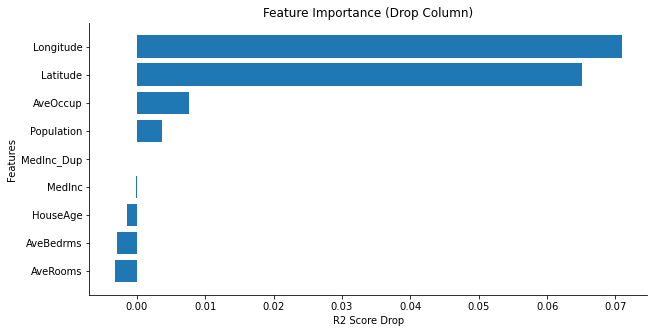

In [16]:
# Drop Column Importance
d_imps = dropcol_importances(rf, X_train_r, y_train_r, X_test_r, y_test_r, r2_score)
drop_imp_ = feature_df(X_train_r.columns.values, d_imps)
hbar(drop_imp_['feature'], drop_imp_['importance'], 'R2 Score Drop', 'Features', 
     'Feature Importance (Drop Column)')

As seen in the above plot, the importance scores for both "MedInc" and its duplicate **dropped to 0** because even if you drop one of them, **the other can cover for it**. Hence, there would be no drop in the validation metric and both variables would be deemed unimportant, which is not right.

Now let's see the effect of duplicate columns on permutation importance:

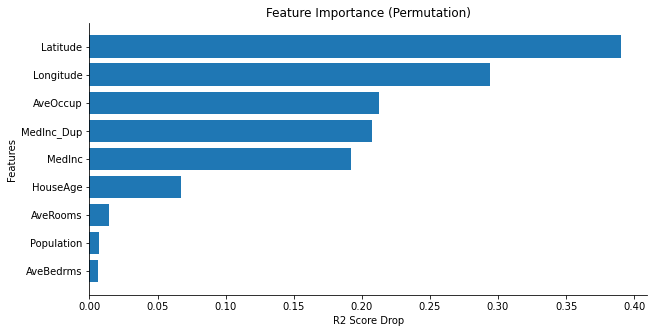

In [17]:
# Permutation Importance
p_imps = permutation_importances(rf, X_test_r, y_test_r, r2_score)
perm_imp_ = feature_df(X_train_r.columns.values, p_imps)
hbar(perm_imp_['feature'], perm_imp_['importance'], 'R2 Score Drop', 'Features', 
     'Feature Importance (Permutation)')

Permuting a duplicated column still allows prediction to be roughly half supported by the other column. Hence, the **importances get shared almost equally.** The reason that there is "half support" is because for Random Forests, during training, node splitting chooses equally important variables in almost equal proportions (50-50). 

In [18]:
# Reset data to original state (no duplicate and random features)
X_train_c, X_test_c, X_train_r, X_test_r = reset_df(X_train_c, X_test_c, X_train_r, X_test_r,
                                                 classification_features, regression_features)

<a id='shap'></a>
## SHAP
SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions. The “game” is the prediction task for a single instance of the dataset. The “gain” is the actual prediction for this instance minus the average prediction for all instances. The “players” are the feature values of the instance that collaborate to receive the gain.

SHAP is one of the best and most widely used packages for feature importance and model intrepretation. It has also been heavily optimized for tree algorithms and hence, works fast with popular algorithms such as XGBoost and LightGBM. 

One of the key advantages of SHAP is that instead of comparing a prediction to the average prediction of the entire dataset, you could compare it to a subset or even to a single data point. SHAP is also model agnostic like permutation and drop importance.

**Caveats:**
- Requires a lot of computing time and runs slow for algorithms for which SHAP has not been optimized (for example, sklearn's Random Forest).
- Like many other permutation-based interpretation methods, SHAP suffers from inclusion of unrealistic data instances when features are correlated.

**Note:** SHAP importances depend on the model being used. We can see this in our next example where we get SHAP values from an XGBoost and RF model.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


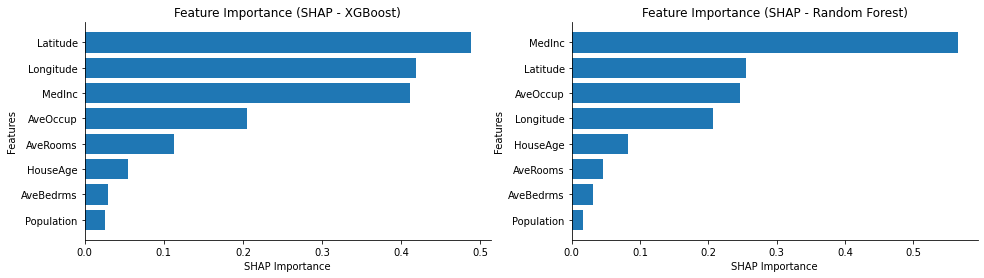

In [19]:
shap_imp_xgb, shap_imp_rf =  shap_XGB_RF(X_train_r, y_train_r)
fig, axes = plt.subplots(figsize=(16, 4), nrows=1, ncols=2)
axes = axes.flatten()
hbar_ax(shap_imp_xgb['feature'], shap_imp_xgb['importance'], 'SHAP Importance', 'Features', 
     'Feature Importance (SHAP - XGBoost)', axes[0])
hbar_ax(shap_imp_rf['feature'], shap_imp_rf['importance'], 'SHAP Importance', 'Features', 
     'Feature Importance (SHAP - Random Forest)', axes[1])     

As seen in the above plot, the feature importances returned by SHAP depends heavily on the underlying model that has been used!

<a id='compare'></a>

## Comparing Importance Strategies

We can compare importance strategies by evaluating their respective feature importances using different models. For the following example, we compared 5 different importance strategies using an OLS, RF and XGBoost model. The ranking of the importance strategies was assessed using a Top-K approach where, first, the most important feature is used for the models, followed by the top 2 most important features and so on. The validation metric used is MAE.

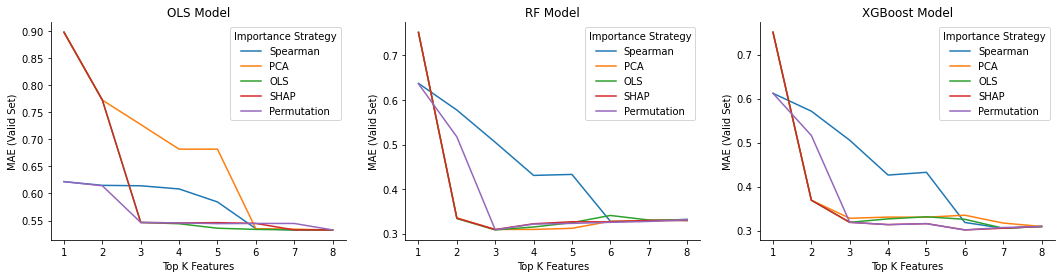

In [20]:
models = {"lr": LinearRegression(),
          "rf": RandomForestRegressor(min_samples_leaf=5, n_jobs=-1),
          "xgb": xgboost.XGBRegressor(min_child_weight=5, n_jobs=-1)}

method_imps = {"spearman": spearman_imp['feature'],
                "pca": pca_imp['feature'],
                "lin": lin_imp['feature'],
                "shap": shap_imp_xgb['feature'],
                "perm": perm_imp['feature']}          
                
plot_model_importances(models, method_imps, X_train_r, y_train_r, X_test_r, y_test_r, mean_absolute_error)                

As seen in the above plots, SHAP and Permutation importances seem to be the most consistent across different models.

<a id='automatic'></a>

## Automatic Feature Selection

Automatic feature selection procedure:
1. Train a model and get baseline validation metric for all features
2. While there are features remaining to be selected:
    1. Get feature importances using a feature importance strategy (default = permutation)
    2. Drop the least important feature, train a new model and recompute the validation metric
    3. If current validation metric is not better than the baseline, break from the loop    
    4. If the current validation metric is better than the baseline, drop the feature from the original data  
    5. Set current validation metric as the baseline  
3. Return selected features

For our example, we will add back in a "random" feature and check if our automatic feature selection is working as expected. 

In [21]:
# Add random feature to train and test
X_train_r['random'] = np.random.random(size=len(X_train_r))
X_test_r['random'] = np.random.random(size=len(X_test_r))
rf = RandomForestRegressor(min_samples_leaf=5, n_jobs=-1, random_state=1)
selected_features = automatic_feature_selection(rf, X_train_r, y_train_r, X_test_r, y_test_r, r2_score)

Starting with 9 features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'random']

Validation Score for 9 features: 0.8004
Removed feature random
Validation Score for 8 features: 0.8020
Removed feature AveBedrms
Validation Score for 7 features: 0.8050

Features selected: ['MedInc', 'HouseAge', 'AveRooms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


We started out with 9 features and ended up with 7 features while simultaneously improving our validation metric!

<a id='variance'></a>

## Variance of Importances

We can compute variance or standard deviation for the feature importances by bootstrapping our training data many times and then recomputing feature importances for each of these bootstrapped datasets. We can then compute the variance of the feature importances using these bootstrapped feature importances.

The following example have error bars that represent two standard deviations around the mean of the feature importances, which were computed using permuation importance. The training data was boostrapped 100 times.

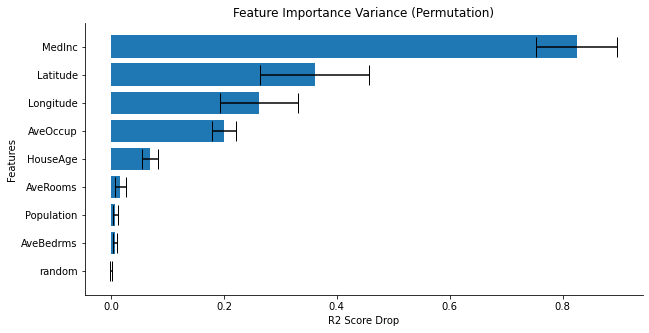

In [22]:
means, stds = importance_variance(rf, X_train_r, y_train_r, X_test_r, y_test_r, r2_score, niter=100)
sorted_idx = np.argsort(means)
means = means[sorted_idx]
stds = stds[sorted_idx]
features = X_test_r.columns[sorted_idx]
hbar_err(features,  means, 2*stds, 'R2 Score Drop', 'Features', 
          'Feature Importance Variance (Permutation)')

<a id='empirical'></a>

## Empirical p-values of Importances

Computing p-values for feature importances can be useful to determing whether a feature importance is significant or not. To compute p-values, we need a null distribution, and this null distribution can be obtained by shuffling the dependent variable and then recomputing the feature importances again. This helps in figuring out whether the feature gave a high feature importance by accident, or if the high feature importance occured due to random chance. 

Once we have our null distribution, we can count how many times a feature importance is as extreme or more extreme than the test feature importance computed as as baseline. If the percentage gets above 5% (signficance level), then the feature importance is not significant. 

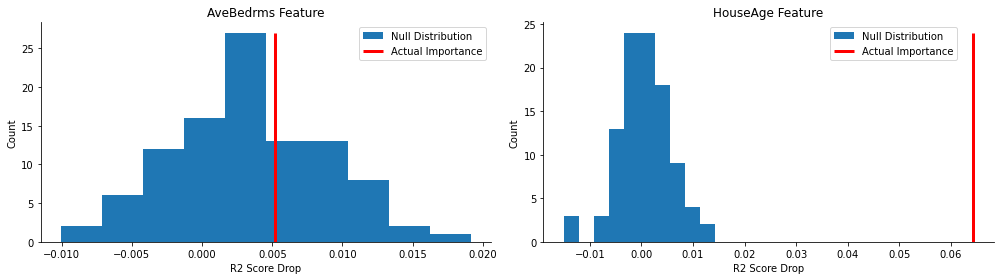

In [23]:
rf.fit(X_train_r.values, y_train_r)
real_importances = permutation_importances(rf, X_test_r, y_test_r, r2_score)
null_importances = importance_pval(rf, X_train_r, y_train_r, X_test_r, y_test_r, r2_score, niter=100)
feature_names = X_train_r.columns
feature1_idx, feature2_idx = 3, 1
plot_null_dist(null_importances, real_importances, feature1_idx, feature2_idx, feature_names)

In [24]:
feature1_pval = get_p_val(null_importances, real_importances, feature1_idx)
feature2_pval = get_p_val(null_importances, real_importances, feature2_idx)
print(f"Empirical P-values\n{feature_names[feature1_idx]}: {feature1_pval}\n{feature_names[feature2_idx]}: {feature2_pval}")

Empirical P-values
AveBedrms: 0.33
HouseAge: 0.0


As seen from the above plots and empirical p-values, the AveBedrms feature importance might not be significant because of its high p-value (0.33 > 0.05), while the HouseAge feature importance is significant (0 < 0.05).

<a id='conclusion'></a>

## Conclusion
To conclude, we discussed multiple feature importance strategies in the report, including its advantages and disadvantages. We also saw how adding noise and duplicate columns can expose weaknesses in a feature importance technique such as the one in Random Forest. According to the report, SHAP and permutation importance might be the most consistent and accurate feature importance strategies. We also saw how feature importances can be used for automatic feature selection which could make models simpler and more general. Finally, we saw how to calculate the variances for feature importances and assessed the significance of these importances as well.


<a id='references'></a>
## References:  
[MRMR - Uber Paper](https://arxiv.org/pdf/1908.05376.pdf)  
[Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)